In [25]:
import tensorflow as tf
import numpy as np
import seaborn as sns
from tensorflow import keras
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore")

## IMPORT DATASET

In [3]:
img_width = 512
img_height = 512
batchsize = 32
epochs = 4
num_of_class = 4

In [4]:
train = keras.utils.image_dataset_from_directory(
    directory = "/Users/tai.nguyen2/Documents/chatgpt/tumour/archive/Training",
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = batchsize,
    image_size = (img_width, img_height)
)

test = keras.utils.image_dataset_from_directory(
    directory = '/Users/tai.nguyen2/Documents/chatgpt/tumour/archive/Testing',
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = batchsize,
    image_size = (img_width, img_height)
)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [5]:
print(train.class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


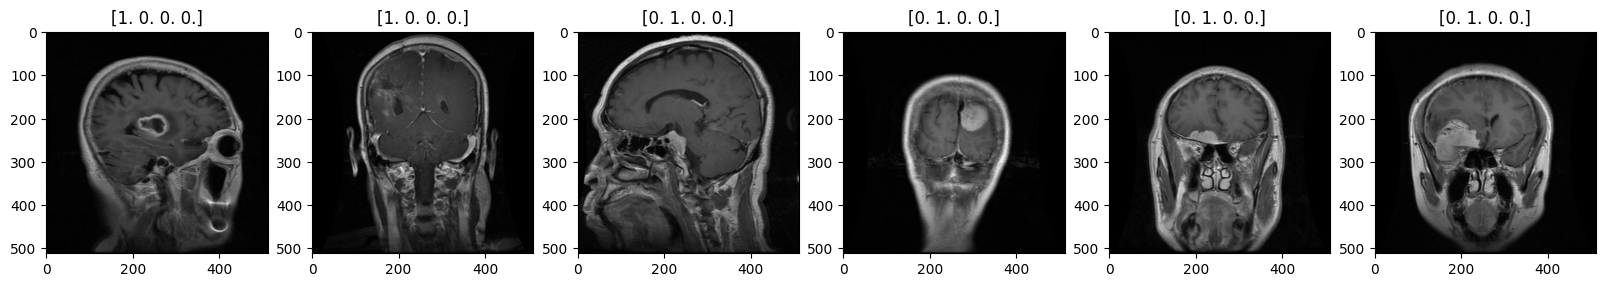

In [6]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=6, figsize=(20,20))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## DATA PREPROCESSING

In [7]:
X_train = []
y_train = []
X_test = []
y_test = []

for feature, label in train:
    X_train.append(feature.numpy())
    y_train.append(label.numpy())
    
for feature, label in test:
    X_test.append(feature.numpy())
    y_test.append(label.numpy())

X_train = np.concatenate(X_train, axis = 0)
y_train = np.concatenate(y_train, axis=0)
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

2024-06-06 19:14:53.406927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-06 19:14:56.990679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5712, 512, 512, 3) (5712, 4) (1311, 512, 512, 3) (1311, 4)


In [9]:
# Normalizing the data
X_train = X_train/256
X_test = X_test/256

## TRANSFER LEARNING

In [10]:
def cnn_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
    for layer in base_model.layers:
        layer.trainable = False
    for i in range(3):
        base_model.layers[-2-i].trainable = True
    # Add custom layers on top of the VGG16 base
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling2D instead of Flatten for better performance
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.05))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = cnn_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 512, 512, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 512, 512, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 256, 256, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 256, 256, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 128, 128, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 128, 128, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 128, 128, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 64, 64, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 64, 64, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 64, 64, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,109,700 (57.64 MB)

 Trainable params: 7,474,436 (28.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [10]:
hist = model.fit(X_train, y_train, epochs= 6)
print(hist.history)

Epoch 1/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 4022s 22s/step - accuracy: 0.4666 - loss: 16.2532
Epoch 2/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 6130s 34s/step - accuracy: 0.8550 - loss: 9.3891
Epoch 3/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 3506s 20s/step - accuracy: 0.8833 - loss: 5.6314
Epoch 4/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 4085s 23s/step - accuracy: 0.9150 - loss: 3.3499
Epoch 5/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 3895s 22s/step - accuracy: 0.9253 - loss: 2.0234
Epoch 6/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 5288s 30s/step - accuracy: 0.9418 - loss: 1.2195
{'accuracy': [0.6185224056243896, 0.8602941036224365, 0.8897058963775635, 0.9194678068161011, 0.9313725233078003, 0.9516806602478027], 'loss': [14.215110778808594, 8.330188751220703, 4.982824802398682, 2.964808464050293, 1.7892975807189941, 1.0824553966522217]}


In [15]:
model = load_model('tumor_v1.keras')

In [16]:
y_predictions = model.predict(X_test)
y_predictions

41/41 ━━━━━━━━━━━━━━━━━━━━ 986s 24s/step


array([[8.37321131e-05, 4.02029930e-03, 6.24573324e-04, 9.95271444e-01],
       [7.09028482e-01, 2.68741727e-01, 8.48099589e-03, 1.37488535e-02],
       [2.94643905e-06, 5.73667385e-05, 9.99938607e-01, 1.03013735e-06],
       ...,
       [2.16040760e-03, 3.86875914e-03, 1.10209058e-03, 9.92868721e-01],
       [3.15954054e-07, 1.81932028e-05, 9.99981403e-01, 1.20934700e-07],
       [5.08640915e-05, 3.91172653e-04, 6.22014122e-05, 9.99495745e-01]],
      dtype=float32)

In [22]:
y_test_arr = np.where(y_test[:, 2] == 0, 0, 1)
# Find the index of the maximum value for each row
max_indices = np.argmax(y_predictions, axis=1)
# Create an output array of the same shape, initialized with zeros
output_array = np.zeros_like(y_predictions)
# Set the maximum value index to 1 for each row
output_array[np.arange(y_predictions.shape[0]), max_indices] = 1

prediction_arr = np.where(output_array[:, 2] == 0, 0, 1)

In [27]:
print(classification_report(y_test_arr, prediction_arr))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       906
           1       0.94      1.00      0.97       405

    accuracy                           0.98      1311
   macro avg       0.97      0.98      0.97      1311
weighted avg       0.98      0.98      0.98      1311



In [11]:
# model.save('tumor_v1.h5')

In [12]:
# model.save('tumor_v1.keras')